In [10]:
!unzip ../content/images.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: images/TELEPHONIE - GPS/TELEPHONIE - GPS_6848.jpg  
  inflating: images/TELEPHONIE - GPS/TELEPHONIE - GPS_6849.jpg  
  inflating: images/TELEPHONIE - GPS/TELEPHONIE - GPS_685.jpg  
  inflating: images/TELEPHONIE - GPS/TELEPHONIE - GPS_6850.jpg  
  inflating: images/TELEPHONIE - GPS/TELEPHONIE - GPS_6851.jpg  
  inflating: images/TELEPHONIE - GPS/TELEPHONIE - GPS_6852.jpg  
  inflating: images/TELEPHONIE - GPS/TELEPHONIE - GPS_6853.jpg  
  inflating: images/TELEPHONIE - GPS/TELEPHONIE - GPS_6854.jpg  
  inflating: images/TELEPHONIE - GPS/TELEPHONIE - GPS_6855.jpg  
  inflating: images/TELEPHONIE - GPS/TELEPHONIE - GPS_6856.jpg  
  inflating: images/TELEPHONIE - GPS/TELEPHONIE - GPS_6857.jpg  
  inflating: images/TELEPHONIE - GPS/TELEPHONIE - GPS_6858.jpg  
  inflating: images/TELEPHONIE - GPS/TELEPHONIE - GPS_6859.jpg  
  inflating: images/TELEPHONIE - GPS/TELEPHONIE - GPS_686.jpg  
  inflating: i

In [11]:
# Importez les bibliothèques nécessaires
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [32]:
TRAIN_DIR = "images/"
IMG_WIDTH = 180
IMG_HEIGHT = 180
BATCH_SIZE = 32

In [33]:
train_datagen = ImageDataGenerator( rescale = 1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 67332 images belonging to 45 classes.
Found 16811 images belonging to 45 classes.


In [34]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(45, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 20, 20, 128)     

In [35]:
# Compilez le modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Entraînez le modèle
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100 ,
                    epochs=10,
                    validation_steps=50)

Epoch 1/10
100/100 [==============================] - 262s 3s/step - loss: 2.4359 - accuracy: 0.4334 - val_loss: 2.1504 - val_accuracy: 0.4275
Epoch 2/10
100/100 [==============================] - 264s 3s/step - loss: 2.1607 - accuracy: 0.4606 - val_loss: 2.0561 - val_accuracy: 0.4437
Epoch 3/10
100/100 [==============================] - 259s 3s/step - loss: 2.0497 - accuracy: 0.4884 - val_loss: 1.8302 - val_accuracy: 0.5631
Epoch 4/10
100/100 [==============================] - 258s 3s/step - loss: 2.0242 - accuracy: 0.4944 - val_loss: 1.9179 - val_accuracy: 0.4919
Epoch 5/10
100/100 [==============================] - 257s 3s/step - loss: 1.9608 - accuracy: 0.5013 - val_loss: 1.7210 - val_accuracy: 0.5675
Epoch 6/10
100/100 [==============================] - 258s 3s/step - loss: 1.9273 - accuracy: 0.5081 - val_loss: 1.7020 - val_accuracy: 0.5738
Epoch 7/10
100/100 [==============================] - 258s 3s/step - loss: 1.9455 - accuracy: 0.5016 - val_loss: 1.6716 - val_accuracy: 0.5713

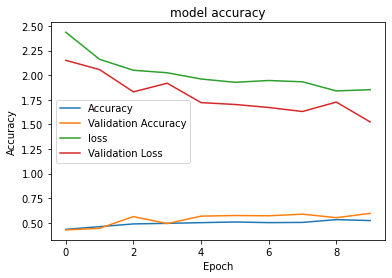

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()